In [268]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [269]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [270]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [271]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [272]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [273]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [274]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [275]:
len(df)

25867

In [276]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [277]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [278]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [279]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [280]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

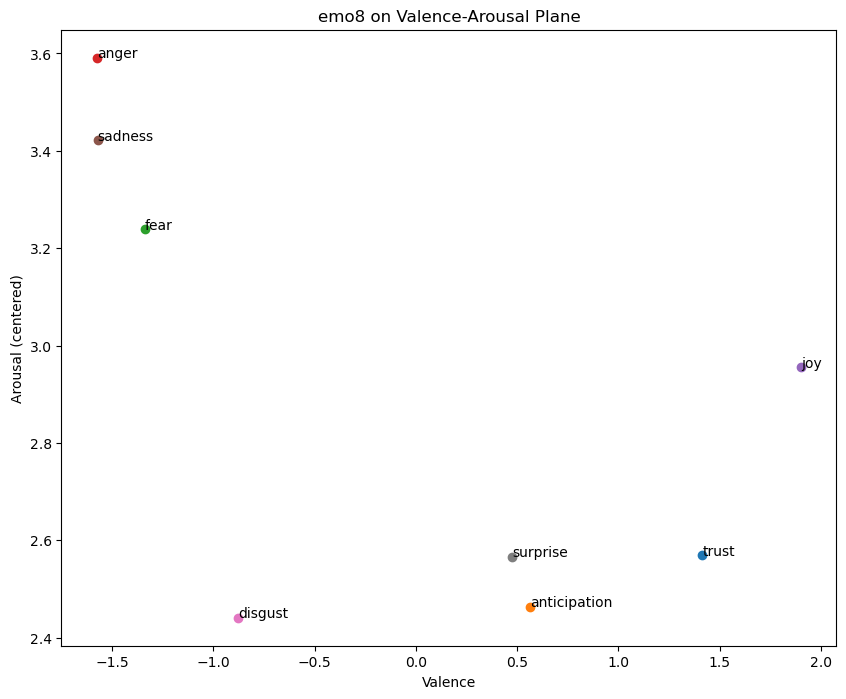

In [281]:
VALENCE_BINS = np.linspace(-3, 3, num=7)
AROUSAL_BINS = np.linspace(0, 6, num=7)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))
emotion_va_bins = {}

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    valence_bin = to_bin(avg_valence, VALENCE_BINS)
    arousal_bin = to_bin(avg_arousal, AROUSAL_BINS)
    emotion_va_bins[emo] = (valence_bin, arousal_bin)
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [282]:
df['valence_bin'] = df['valence'].apply(lambda x: to_bin(x, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda x: to_bin(x, AROUSAL_BINS))

In [283]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,3,2
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,3,2
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,2
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,4,2
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,3


In [284]:
emotion_va_bins

{'trust': (4, 3),
 'anticipation': (4, 2),
 'fear': (2, 3),
 'anger': (1, 4),
 'joy': (5, 3),
 'sadness': (1, 3),
 'disgust': (2, 2),
 'surprise': (3, 3)}

In [285]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [286]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [287]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [288]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [289]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [290]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [291]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [292]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [293]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [294]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [295]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [296]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "scenes_5"), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        tensor = super().__getitem__(f"scene_{i}")
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

# DPL with symbolic knowledge about the data

In [297]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        output = self.module(*args, **kwargs)

        # Flatten output if it has extra dimensions
        if isinstance(output, torch.Tensor) and output.dim() == 3:
            output = output.squeeze(1)  # Remove the middle dimension [B, 1, C] -> [B, C]
        
        return output
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [298]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [299]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

# Initialize the models, network and final DPL model

In [300]:
class FaceValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)
        

In [301]:
from coral_pytorch.losses import corn_loss

def custom_loss(logits, y, NUM_CLASSES, class_weights=None):
    loss = corn_loss(logits, y, NUM_CLASSES)

    if class_weights is not None:
        weights = class_weights[y]
        loss = (loss * weights).mean()

    else:
        loss = loss.mean()

    return loss

In [302]:
from coral_pytorch.dataset import corn_label_from_logits

def train_epoch(model, loader, optimizer, NUM_CLASSES=None, class_weights=None):
    model.train()
    total_loss = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0
    mae = 0
    mse = 0

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).long()  # CE requires long dtype

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)                    # (B, num_bins)
        loss = custom_loss(logits, y, NUM_CLASSES, class_weights=class_weights)
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        total_loss += loss.item() * x.size(0)
        predicted_labels = corn_label_from_logits(logits).float()

        mae += torch.sum(torch.abs(predicted_labels - y.float()))
        mse += torch.sum((predicted_labels - y.float()) ** 2)

        adjacent_correct = ((predicted_labels - y.float()).abs() <= 1).sum().item()
        total_correct_adjacent += adjacent_correct

        total_samples += x.size(0)

    # Overall metrics
    epoch_loss = total_loss / total_samples
    epoch_acc_adj = total_correct_adjacent / total_samples if total_samples > 0 else 0
    epoch_mae = mae.item() / total_samples
    epoch_mse = mse.item() / total_samples

    return epoch_loss, epoch_acc_adj, epoch_mae, epoch_mse

In [303]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, labels, NUM_CLASSES, allow_adjacent=True):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0
    mae = torch.tensor(0.0, device=DEVICE)
    mse = torch.tensor(0.0, device=DEVICE)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = custom_loss(logits, y, NUM_CLASSES)

            total_loss += loss.item() * x.size(0)
            predicted_labels = corn_label_from_logits(logits).float()

            mae += torch.sum(torch.abs(predicted_labels - y))
            mse += torch.sum((predicted_labels - y)**2)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted_labels.cpu().numpy())
            
            # Adjacent matches (within 1 bin)
            if allow_adjacent:
                adjacent_correct = ((predicted_labels - y).abs() <= 1).sum().item()
                total_correct_adjacent += adjacent_correct
            
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(labels)), zero_division=0
    )
    
    # Overall metrics
    accuracy_adjacent = total_correct_adjacent / total_samples if allow_adjacent else None
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy_adjacent': accuracy_adjacent,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'mae': mae.item() / total_samples,
        'mse': mse.item() / total_samples
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:                {results['loss']:.4f}")
    if results.get('accuracy_adjacent') is not None:
        print(f"Accuracy (±1 bin):   {results['accuracy_adjacent']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Label':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    print(f"{'MAE':<15} {results['mae']:<12.4f}")
    print(f"{'MSE':<15} {results['mse']:<12.4f}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [304]:
class AdaptiveEarlyStopping:
    """Early stopping with adaptive min_delta based on initial loss scale"""
    def __init__(self, patience=7, min_delta_pct=0.01, mode='min', verbose=True):
        """
        Args:
            patience: How many epochs to wait after last improvement
            min_delta_pct: Minimum % improvement (e.g., 0.01 = 1% improvement needed)
            mode: 'min' for loss, 'max' for accuracy
            verbose: Print messages
        """
        self.patience = patience
        self.min_delta_pct = min_delta_pct
        self.min_delta = None  # Will be set based on first score
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, score, epoch):
        # Initialize on first call
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            # Set min_delta as percentage of initial score
            self.min_delta = abs(score * self.min_delta_pct)
            if self.verbose:
                print(f"Initial score: {score:.4f}")
                print(f"Min delta set to: {self.min_delta:.6f} ({self.min_delta_pct*100:.1f}% of score)")
            return False
        
        # Check if score improved
        if self.mode == 'min':
            improved = score < (self.best_score - self.min_delta)
        else:
            improved = score > (self.best_score + self.min_delta)
        
        if improved:
            improvement = abs(score - self.best_score)
            improvement_pct = (improvement / self.best_score) * 100
            if self.verbose:
                print(f"Score improved: {self.best_score:.4f} → {score:.4f} (Δ={improvement:.4f}, {improvement_pct:.2f}%)")
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement for {self.counter}/{self.patience} epochs (best: {self.best_score:.4f} @ epoch {self.best_epoch})")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"\n{'='*70}")
                    print(f"Early stopping triggered!")
                    print(f"Best score: {self.best_score:.4f} at epoch {self.best_epoch}")
                    print(f"{'='*70}\n")
                return True
        
        return False

In [305]:
valence_bin_labels = [f"V{i}" for i in range(len(VALENCE_BINS))]
arousal_bin_labels = [f"A{i}" for i in range(len(AROUSAL_BINS))]

In [306]:
# Show how many samples per valence bin in the training set
train_valence_counts = df.loc[train_indices]['valence_bin'].value_counts().sort_index()
print("Training set valence bin counts:")
print(train_valence_counts)

# Show how many samples per arousal bin in the training set
train_arousal_counts = df.loc[train_indices]['arousal_bin'].value_counts().sort_index()
print("Training set arousal bin counts:")
print(train_arousal_counts)

Training set valence bin counts:
valence_bin
0    1491
1    2446
2    2872
3    2735
4    4575
5    4122
6    2452
Name: count, dtype: int64
Training set arousal bin counts:
arousal_bin
0    1123
1    3676
2    4305
3    4098
4    3609
5    2433
6    1449
Name: count, dtype: int64


# Face Valence Predictor

In [307]:
from deepproblog.utils.standard_networks import MLP
face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS) - 1,       # output size (valence bins), -1 for the corn_loss   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)


Epoch 1/100


Train Loss: 0.0783, Train Adjacent Accuracy: 0.5965, Train MAE: 1.4850, Train MSE: 3.7165

Epoch 2/100


Train Loss: 0.0745, Train Adjacent Accuracy: 0.6480, Train MAE: 1.3140, Train MSE: 2.9959

Epoch 3/100


Train Loss: 0.0733, Train Adjacent Accuracy: 0.6647, Train MAE: 1.2843, Train MSE: 2.8784


New best model! (MSE: 2.8690)
Initial score: 2.8690
Min delta set to: 0.028690 (1.0% of score)

Overall Metrics:
Loss:                0.4251
Accuracy (±1 bin):   0.6508

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2414       0.0185       0.0343       379       
V1              0.2555       0.4391       0.3230       583       
V2              0.1965       0.4011       0.2638       698       
V3              0.1823       0.2769       0.2198       668       
V4              0.2964       0.1287       0.1794       1228      
V5              0.3591       0.2554       0.2985       1018      
V6              0.3879       0.2883       0.3308       600       
----------------------------------------------------------------------
Macro Avg       0.2742       0.2583       0.2357       5174      
Weighted Avg    0.2825       0.2549       0.2426       5174      
MAE      

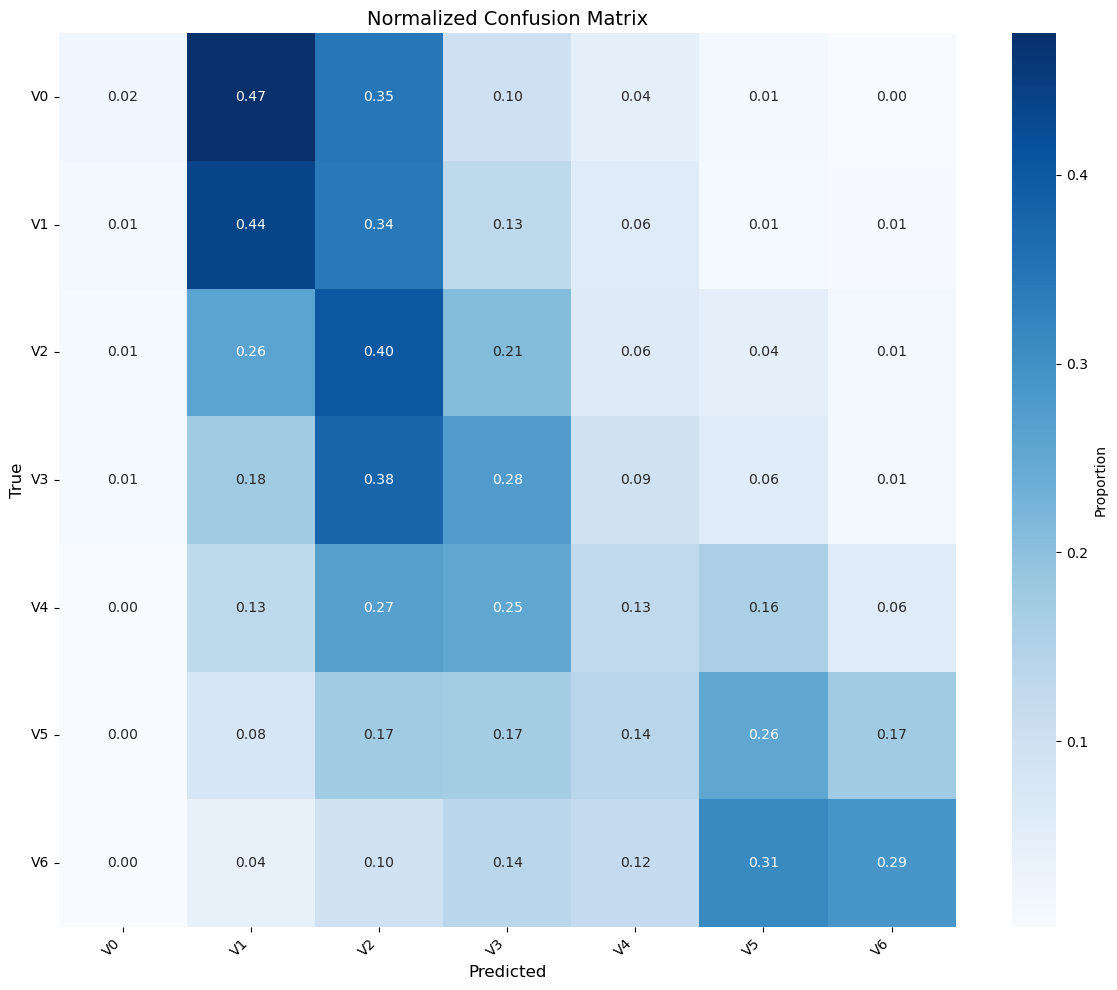


Epoch 4/100


Train Loss: 0.0730, Train Adjacent Accuracy: 0.6749, Train MAE: 1.2564, Train MSE: 2.7921

Epoch 5/100


Train Loss: 0.0723, Train Adjacent Accuracy: 0.6741, Train MAE: 1.2478, Train MSE: 2.8094

Epoch 6/100


Train Loss: 0.0713, Train Adjacent Accuracy: 0.6891, Train MAE: 1.2136, Train MSE: 2.7030


No improvement for 1/5 epochs (best: 2.8690 @ epoch 3)

Overall Metrics:
Loss:                0.4303
Accuracy (±1 bin):   0.6401

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2698       0.1530       0.1953       379       
V1              0.2236       0.4357       0.2955       583       
V2              0.1973       0.3496       0.2522       698       
V3              0.1886       0.2680       0.2214       668       
V4              0.3040       0.1124       0.1641       1228      
V5              0.3514       0.2544       0.2952       1018      
V6              0.4103       0.3050       0.3499       600       
----------------------------------------------------------------------
Macro Avg       0.2778       0.2683       0.2534       5174      
Weighted Avg    0.2848       0.2542       0.2478       5174      
MAE             1.3288      
MSE             3.09

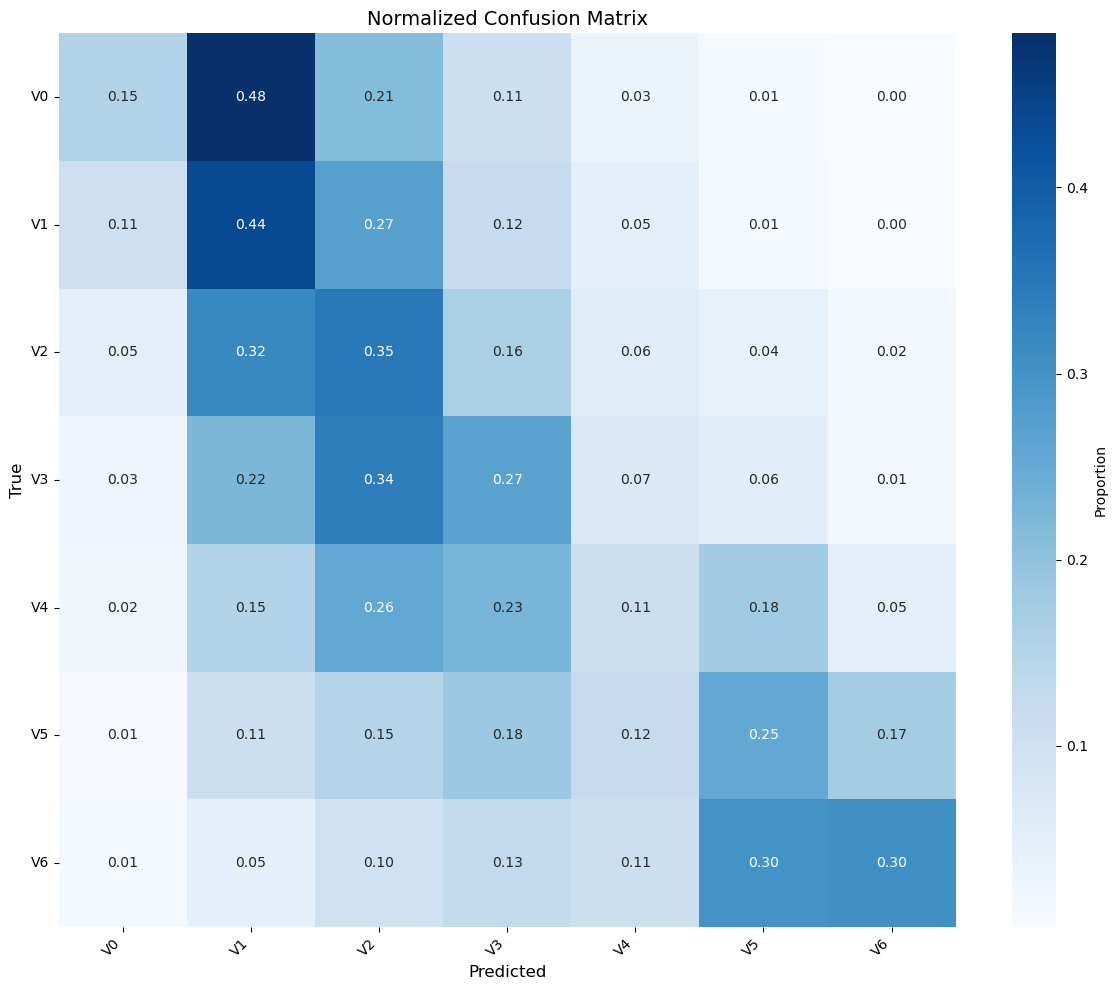


Epoch 7/100


Train Loss: 0.0708, Train Adjacent Accuracy: 0.6913, Train MAE: 1.2113, Train MSE: 2.7367

Epoch 8/100


Train Loss: 0.0708, Train Adjacent Accuracy: 0.6930, Train MAE: 1.2086, Train MSE: 2.7325

Epoch 9/100


Train Loss: 0.0712, Train Adjacent Accuracy: 0.6992, Train MAE: 1.1866, Train MSE: 2.6558


New best model! (MSE: 2.6426)
Score improved: 2.8690 → 2.6426 (Δ=0.2263, 7.89%)

Overall Metrics:
Loss:                0.4148
Accuracy (±1 bin):   0.6728

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2737       0.0686       0.1097       379       
V1              0.2597       0.3431       0.2956       583       
V2              0.2184       0.4054       0.2839       698       
V3              0.1988       0.3518       0.2541       668       
V4              0.3233       0.1669       0.2202       1228      
V5              0.3727       0.2790       0.3191       1018      
V6              0.4207       0.3050       0.3536       600       
----------------------------------------------------------------------
Macro Avg       0.2953       0.2743       0.2623       5174      
Weighted Avg    0.3033       0.2737       0.2685       5174      
MAE             1.2217  

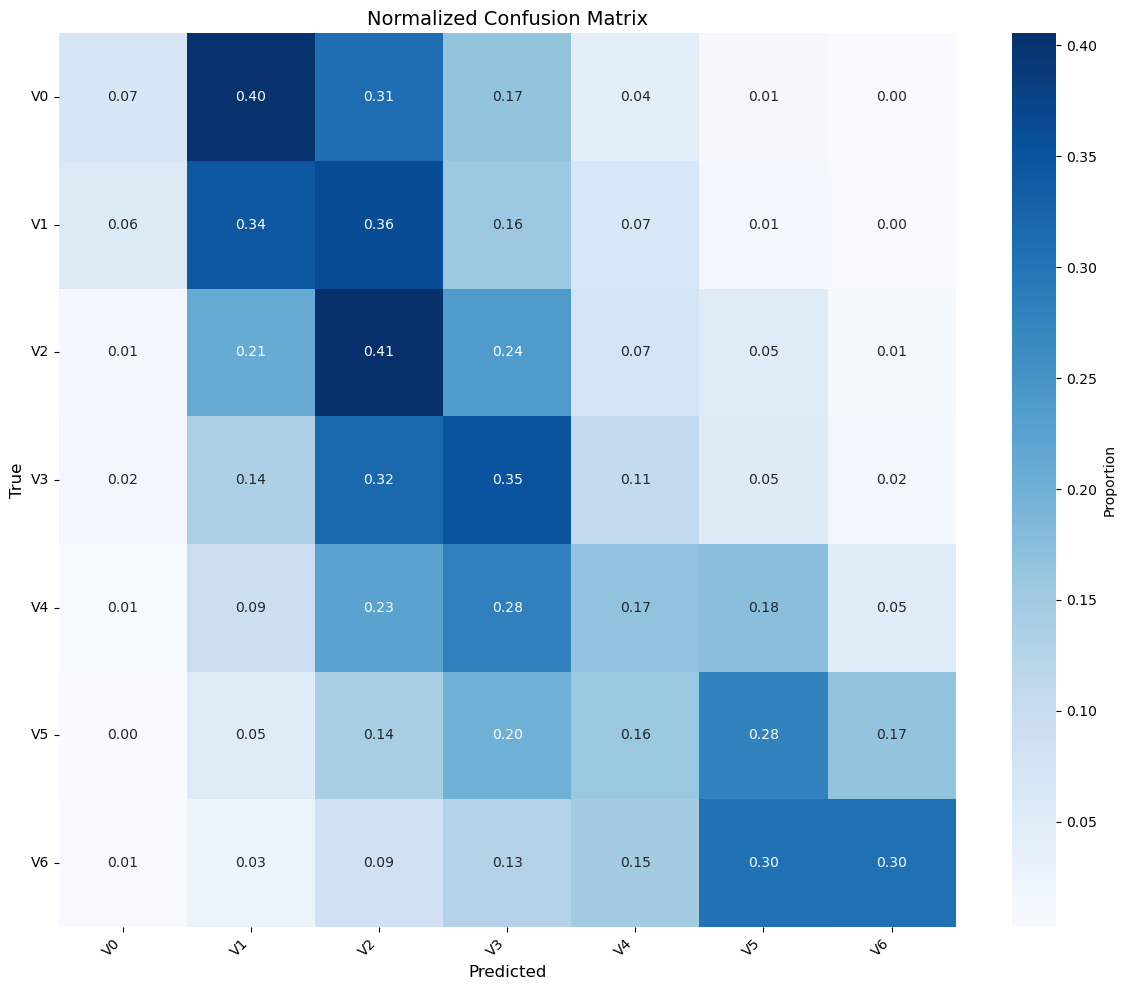


Epoch 10/100


Train Loss: 0.0696, Train Adjacent Accuracy: 0.7009, Train MAE: 1.1707, Train MSE: 2.6234

Epoch 11/100


Train Loss: 0.0690, Train Adjacent Accuracy: 0.7134, Train MAE: 1.1460, Train MSE: 2.5523

Epoch 12/100


Train Loss: 0.0687, Train Adjacent Accuracy: 0.7086, Train MAE: 1.1541, Train MSE: 2.6003


No improvement for 1/5 epochs (best: 2.6426 @ epoch 9)

Overall Metrics:
Loss:                0.4207
Accuracy (±1 bin):   0.6622

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2897       0.1926       0.2314       379       
V1              0.2321       0.3499       0.2791       583       
V2              0.2096       0.3367       0.2584       698       
V3              0.2027       0.3099       0.2451       668       
V4              0.3145       0.1539       0.2067       1228      
V5              0.3516       0.2525       0.2939       1018      
V6              0.3884       0.3683       0.3781       600       
----------------------------------------------------------------------
Macro Avg       0.2841       0.2805       0.2704       5174      
Weighted Avg    0.2907       0.2679       0.2656       5174      
MAE             1.2683      
MSE             2.88

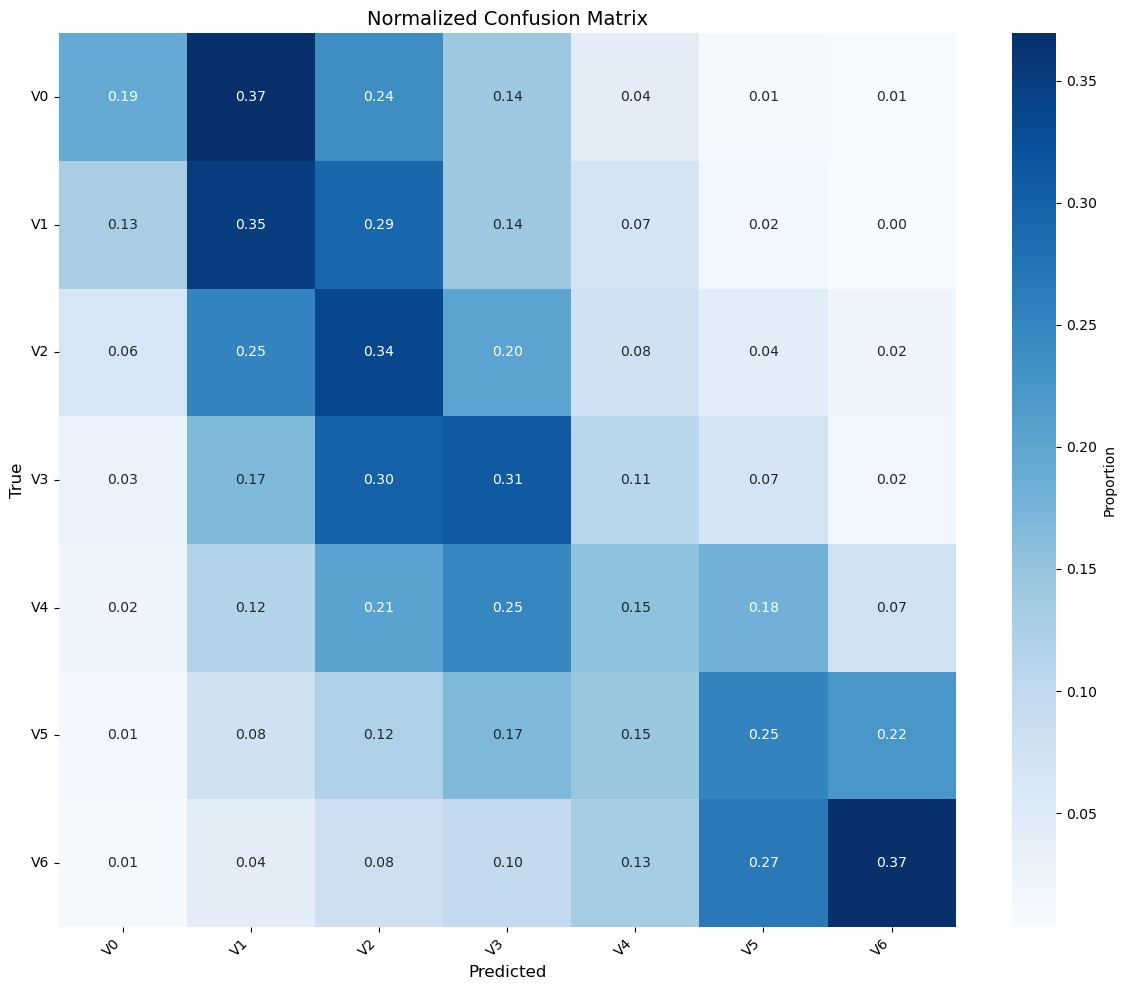


Epoch 13/100


Train Loss: 0.0687, Train Adjacent Accuracy: 0.7118, Train MAE: 1.1433, Train MSE: 2.5838

Epoch 14/100


Train Loss: 0.0681, Train Adjacent Accuracy: 0.7164, Train MAE: 1.1310, Train MSE: 2.5221

Epoch 15/100


Train Loss: 0.0673, Train Adjacent Accuracy: 0.7224, Train MAE: 1.1117, Train MSE: 2.4707


No improvement for 2/5 epochs (best: 2.6426 @ epoch 9)

Overall Metrics:
Loss:                0.4274
Accuracy (±1 bin):   0.6523

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2838       0.2269       0.2522       379       
V1              0.2152       0.3928       0.2781       583       
V2              0.2013       0.3009       0.2412       698       
V3              0.1897       0.2769       0.2252       668       
V4              0.3110       0.1246       0.1779       1228      
V5              0.3562       0.3006       0.3261       1018      
V6              0.4018       0.2933       0.3391       600       
----------------------------------------------------------------------
Macro Avg       0.2799       0.2737       0.2628       5174      
Weighted Avg    0.2872       0.2600       0.2571       5174      
MAE             1.3172      
MSE             3.10

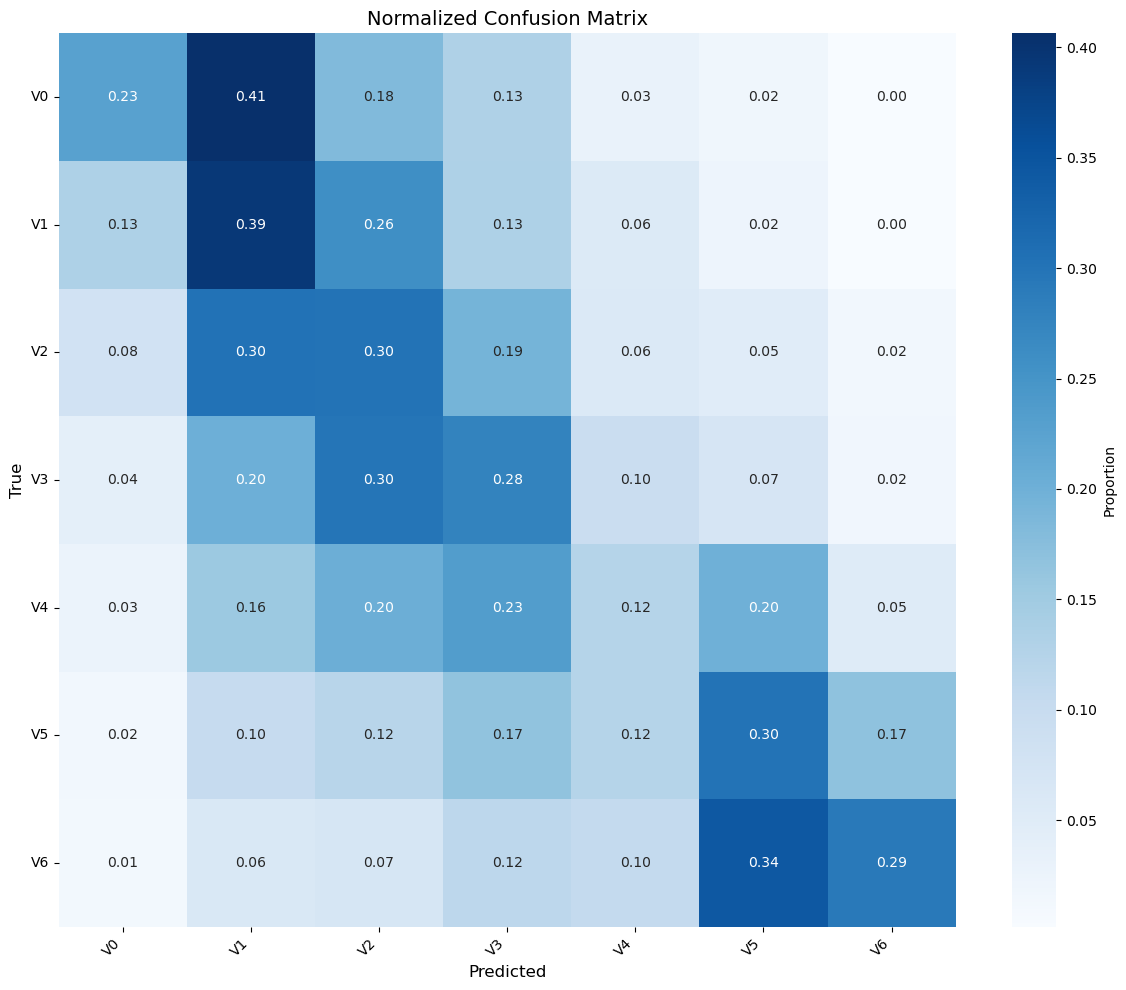


Epoch 16/100


Train Loss: 0.0659, Train Adjacent Accuracy: 0.7283, Train MAE: 1.0918, Train MSE: 2.4012

Epoch 17/100


Train Loss: 0.0654, Train Adjacent Accuracy: 0.7257, Train MAE: 1.0905, Train MSE: 2.4334

Epoch 18/100


Train Loss: 0.0658, Train Adjacent Accuracy: 0.7333, Train MAE: 1.0672, Train MSE: 2.3863


No improvement for 3/5 epochs (best: 2.6426 @ epoch 9)

Overall Metrics:
Loss:                0.4302
Accuracy (±1 bin):   0.6457

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2488       0.2744       0.2610       379       
V1              0.2254       0.3105       0.2612       583       
V2              0.2034       0.3238       0.2499       698       
V3              0.2040       0.2740       0.2339       668       
V4              0.3301       0.1401       0.1967       1228      
V5              0.3372       0.2593       0.2932       1018      
V6              0.3697       0.3950       0.3820       600       
----------------------------------------------------------------------
Macro Avg       0.2741       0.2824       0.2682       5174      
Weighted Avg    0.2850       0.2642       0.2611       5174      
MAE             1.3204      
MSE             3.14

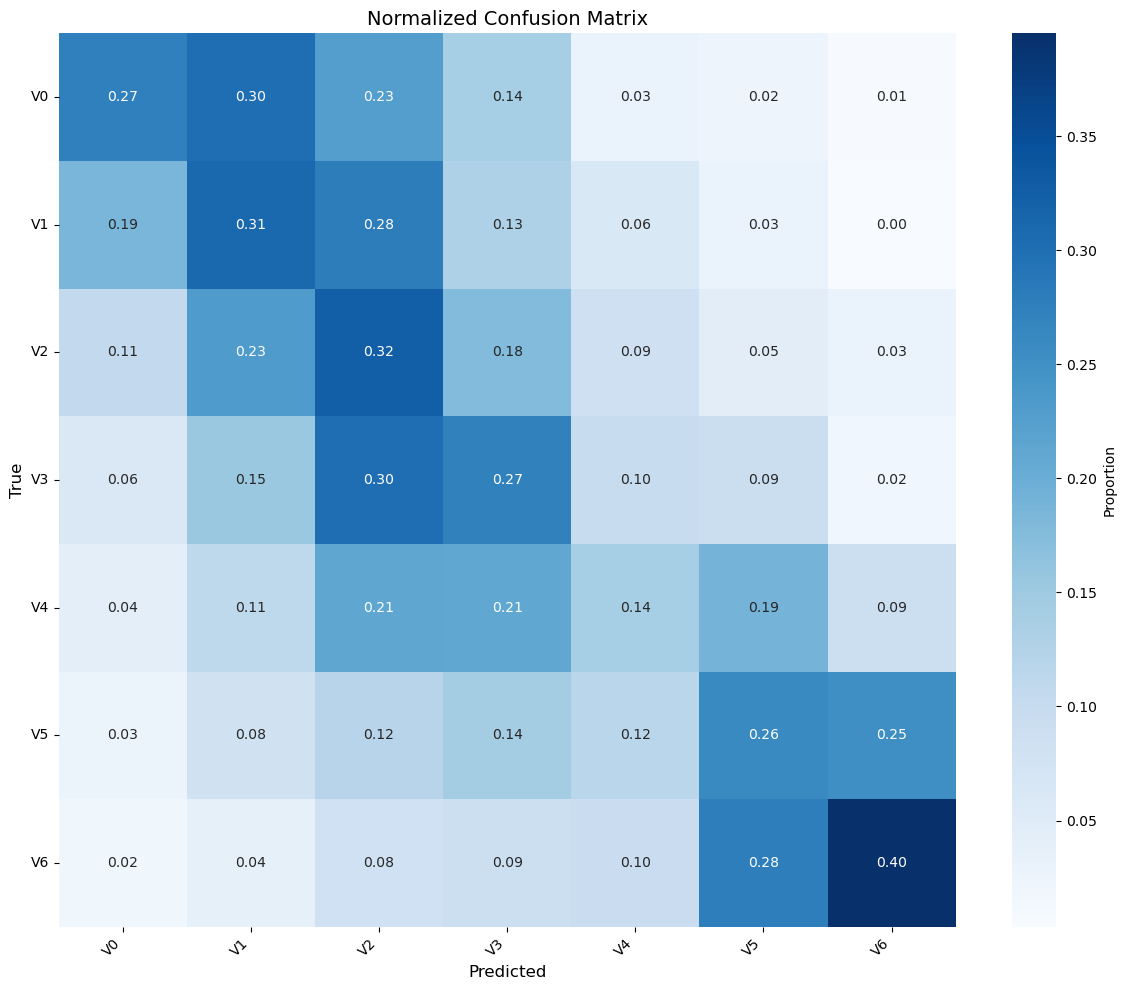


Epoch 19/100


Train Loss: 0.0646, Train Adjacent Accuracy: 0.7337, Train MAE: 1.0566, Train MSE: 2.3487

Epoch 20/100


Train Loss: 0.0633, Train Adjacent Accuracy: 0.7451, Train MAE: 1.0255, Train MSE: 2.2295

Epoch 21/100


Train Loss: 0.0633, Train Adjacent Accuracy: 0.7423, Train MAE: 1.0372, Train MSE: 2.2867


No improvement for 4/5 epochs (best: 2.6426 @ epoch 9)

Overall Metrics:
Loss:                0.4228
Accuracy (±1 bin):   0.6693

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2600       0.1715       0.2067       379       
V1              0.2338       0.2727       0.2518       583       
V2              0.2163       0.3266       0.2603       698       
V3              0.2091       0.3698       0.2672       668       
V4              0.3206       0.1637       0.2167       1228      
V5              0.3350       0.2672       0.2973       1018      
V6              0.3754       0.3567       0.3658       600       
----------------------------------------------------------------------
Macro Avg       0.2786       0.2755       0.2665       5174      
Weighted Avg    0.2871       0.2679       0.2655       5174      
MAE             1.2524      
MSE             2.81

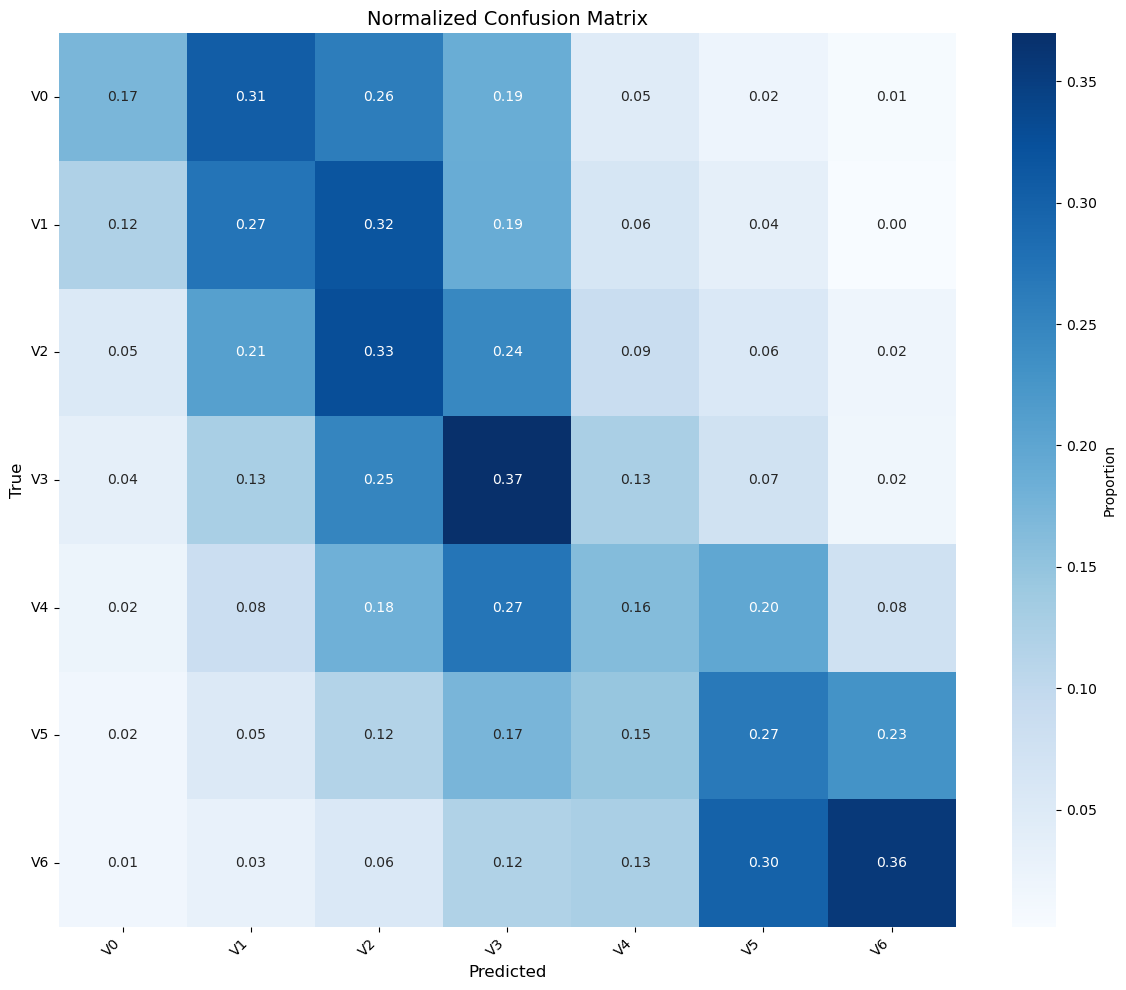


Epoch 22/100


Train Loss: 0.0632, Train Adjacent Accuracy: 0.7503, Train MAE: 1.0122, Train MSE: 2.2325

Epoch 23/100


Train Loss: 0.0621, Train Adjacent Accuracy: 0.7576, Train MAE: 0.9943, Train MSE: 2.1674

Epoch 24/100


Train Loss: 0.0611, Train Adjacent Accuracy: 0.7572, Train MAE: 0.9874, Train MSE: 2.1568


No improvement for 5/5 epochs (best: 2.6426 @ epoch 9)

Early stopping triggered!
Best score: 2.6426 at epoch 9

Early stopping triggered. Stopping training.

Loading best model (Val MSE: 2.6426)


In [308]:
from torch.utils.data import WeightedRandomSampler

MAX_EPOCHS = 100
PATIENCE = 5

optimizer = torch.optim.AdamW(
    face_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Calculate weights
train_labels = [df.loc[train_indices[i], 'valence_bin'] for i in range(len(train_indices))]
class_counts = np.bincount(train_labels)
class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
class_weights_np = class_weights_np / class_weights_np.sum()
class_weights = torch.tensor(class_weights_np, device=DEVICE)

face_val_train_dataset = FaceValDataset(train_indices)
face_val_test_dataset = FaceValDataset(test_indices)

# Oversampling
sample_weights = [class_weights_np[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

face_val_train_loader = DataLoader(
    face_val_train_dataset, 
    batch_size=batch_size, 
    sampler=sampler
)

face_val_test_loader = DataLoader(face_val_test_dataset, batch_size=batch_size, shuffle=False)

early_stopping = AdaptiveEarlyStopping(
    patience=PATIENCE,
    min_delta_pct=0.01,
    mode='min',
    verbose=True
)

# Track best model
best_model_state = None
best_val_mse = float('inf')

for epoch in range(MAX_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{MAX_EPOCHS}")
    
    # Train
    train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
        face_val_model, 
        face_val_train_loader, 
        optimizer, 
        NUM_CLASSES=len(VALENCE_BINS),
        class_weights=class_weights
    )
    print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
    if (epoch + 1) % 3 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_val_model, 
            face_val_test_loader, 
            valence_bin_labels, 
            NUM_CLASSES=len(VALENCE_BINS)
        )
    
        val_mse = results['mse']

        # Save best model based on validation MSE
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model_state = face_val_model.state_dict().copy()
            print(f"New best model! (MSE: {best_val_mse:.4f})")
        
        if early_stopping(val_mse, epoch + 1):
            print("Early stopping triggered. Stopping training.")
            break

        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)


# Load and save best model
print(f"\nLoading best model (Val MSE: {best_val_mse:.4f})")
face_val_model.load_state_dict(best_model_state)
torch.save(face_val_model.state_dict(), os.path.join(model_dir, "face_val_model.pth"))


Overall Metrics:
Loss:                0.4346
Accuracy (±1 bin):   0.6394

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2098       0.2032       0.2064       379       
V1              0.2235       0.3002       0.2562       583       
V2              0.1830       0.3109       0.2304       698       
V3              0.2073       0.2725       0.2354       668       
V4              0.3188       0.1433       0.1978       1228      
V5              0.3304       0.2250       0.2677       1018      
V6              0.3650       0.4350       0.3970       600       
----------------------------------------------------------------------
Macro Avg       0.2626       0.2700       0.2558       5174      
Weighted Avg    0.2750       0.2545       0.2511       5174      
MAE             1.3264      
MSE             3.1030      


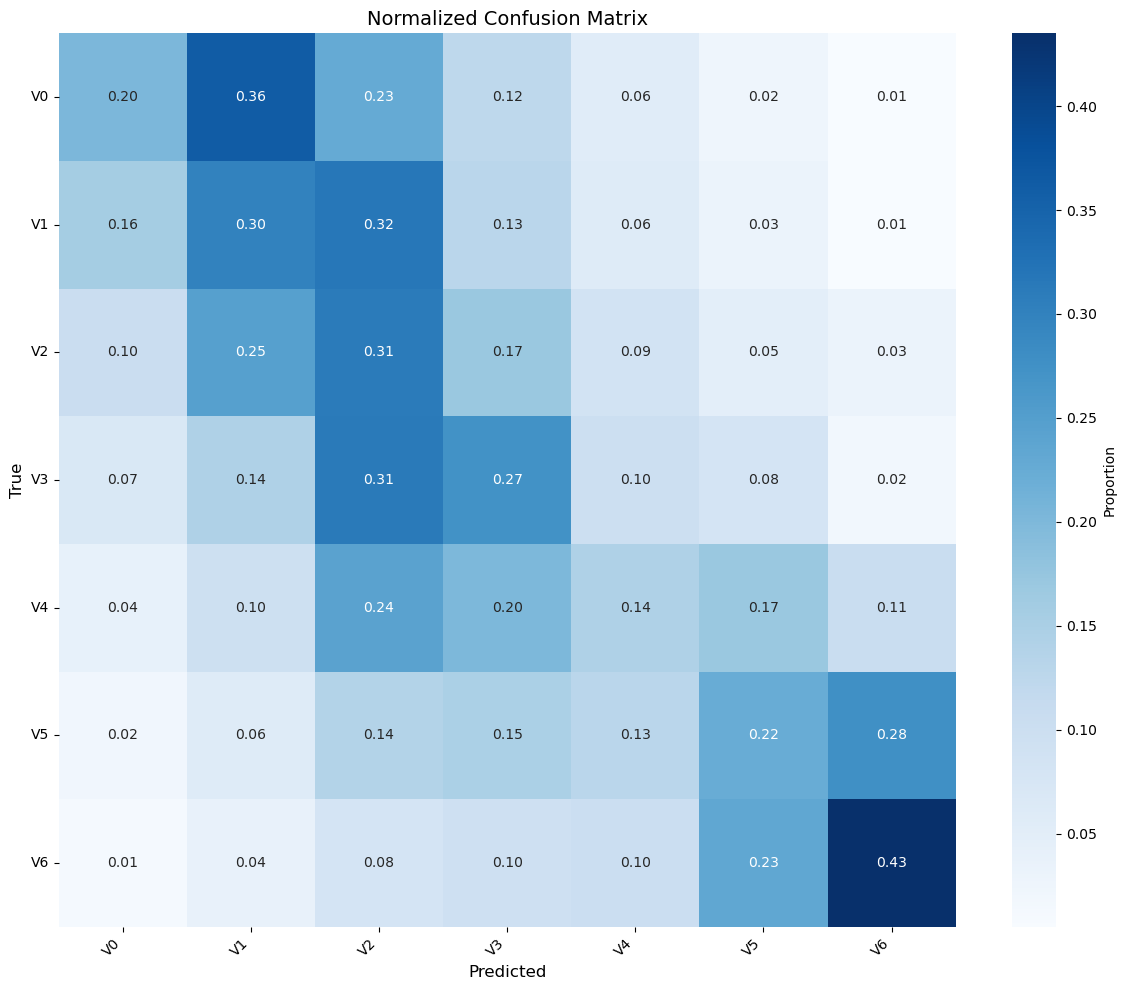

In [309]:
# Load the best model for evaluation
face_val_model.load_state_dict(torch.load(os.path.join(model_dir, "face_val_model.pth")))

final_results = evaluate_with_metrics(
    face_val_model,
    face_val_test_loader,
    valence_bin_labels,
    NUM_CLASSES=len(VALENCE_BINS)
)   
print_detailed_metrics(final_results, valence_bin_labels)
plot_confusion_matrix(final_results['confusion_matrix'], valence_bin_labels, normalize=True)

# Face Arousal Predictor

In [264]:
class FaceAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [265]:
face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS) - 1,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)


Epoch 1/20


Train Loss: 0.0695, Train Adjacent Accuracy: 0.6408, Train MAE: 1.2390, Train MSE: 2.8802

Epoch 2/20


Train Loss: 0.0696, Train Adjacent Accuracy: 0.6470, Train MAE: 1.2127, Train MSE: 2.8097

Epoch 3/20


Train Loss: 0.0673, Train Adjacent Accuracy: 0.6545, Train MAE: 1.1883, Train MSE: 2.7049

Epoch 4/20


Train Loss: 0.0668, Train Adjacent Accuracy: 0.6597, Train MAE: 1.1691, Train MSE: 2.6592

Epoch 5/20


Train Loss: 0.0663, Train Adjacent Accuracy: 0.6680, Train MAE: 1.1514, Train MSE: 2.6213



Overall Metrics:
Loss:                0.5521
Accuracy (±1 bin):   0.5336

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0408       0.0347       0.0375       288       
A1              0.2490       0.0677       0.1065       901       
A2              0.2558       0.1603       0.1971       1092      
A3              0.1981       0.2657       0.2270       1035      
A4              0.1856       0.2732       0.2210       915       
A5              0.1677       0.2652       0.2055       592       
A6              0.1185       0.1111       0.1147       351       
----------------------------------------------------------------------
Macro Avg       0.1737       0.1683       0.1585       5174      
Weighted Avg    0.1993       0.1869       0.1780       5174      
MAE             1.6164      
MSE             4.1865      


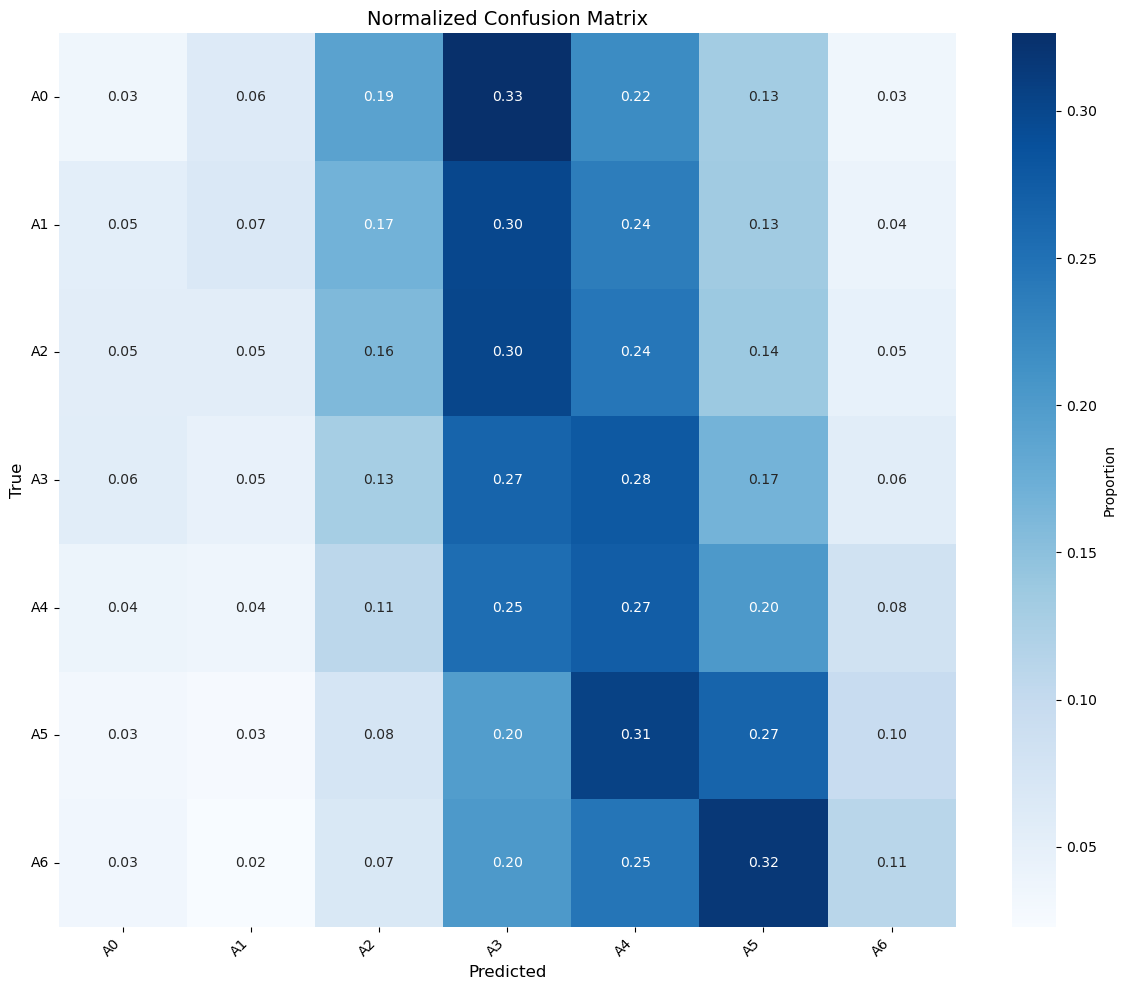


Epoch 6/20


Train Loss: 0.0648, Train Adjacent Accuracy: 0.6815, Train MAE: 1.1064, Train MSE: 2.4836

Epoch 7/20


Train Loss: 0.0642, Train Adjacent Accuracy: 0.6851, Train MAE: 1.1017, Train MSE: 2.4789

Epoch 8/20


Train Loss: 0.0634, Train Adjacent Accuracy: 0.6845, Train MAE: 1.0890, Train MSE: 2.4155

Epoch 9/20


Train Loss: 0.0637, Train Adjacent Accuracy: 0.6907, Train MAE: 1.0724, Train MSE: 2.4222

Epoch 10/20


Train Loss: 0.0622, Train Adjacent Accuracy: 0.7006, Train MAE: 1.0495, Train MSE: 2.2977



Overall Metrics:
Loss:                0.5651
Accuracy (±1 bin):   0.5230

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0602       0.0799       0.0687       288       
A1              0.2317       0.0633       0.0994       901       
A2              0.2358       0.1676       0.1959       1092      
A3              0.1988       0.2850       0.2342       1035      
A4              0.1834       0.2350       0.2060       915       
A5              0.1687       0.2111       0.1875       592       
A6              0.1153       0.1225       0.1188       351       
----------------------------------------------------------------------
Macro Avg       0.1706       0.1663       0.1587       5174      
Weighted Avg    0.1928       0.1819       0.1753       5174      
MAE             1.6407      
MSE             4.3048      


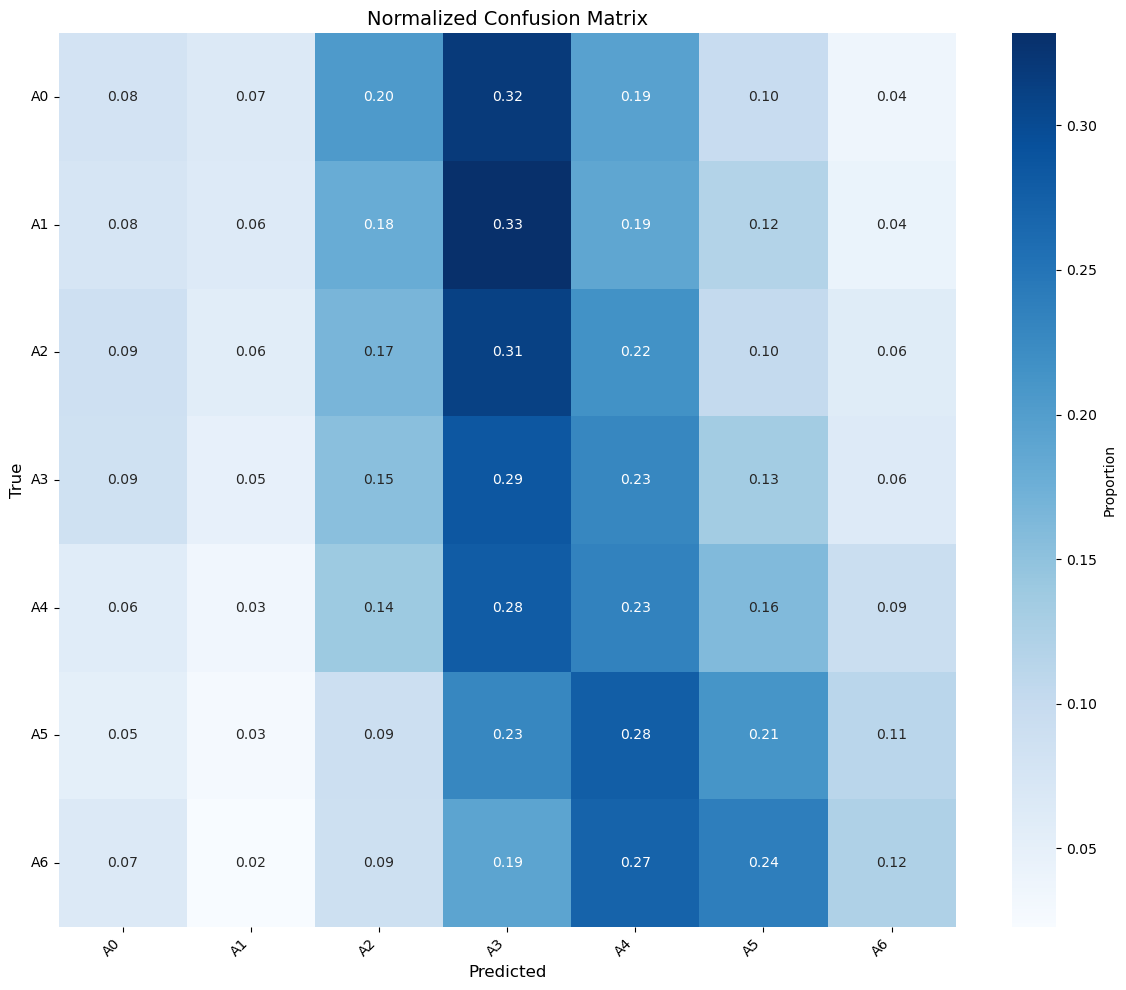


Epoch 11/20


Train Loss: 0.0609, Train Adjacent Accuracy: 0.7055, Train MAE: 1.0364, Train MSE: 2.2883

Epoch 12/20


Train Loss: 0.0608, Train Adjacent Accuracy: 0.7091, Train MAE: 1.0303, Train MSE: 2.2677

Epoch 13/20


Train Loss: 0.0601, Train Adjacent Accuracy: 0.7101, Train MAE: 1.0135, Train MSE: 2.2381

Epoch 14/20


Train Loss: 0.0587, Train Adjacent Accuracy: 0.7206, Train MAE: 0.9900, Train MSE: 2.1330

Epoch 15/20


Train Loss: 0.0588, Train Adjacent Accuracy: 0.7192, Train MAE: 0.9985, Train MSE: 2.1827



Overall Metrics:
Loss:                0.5712
Accuracy (±1 bin):   0.5282

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0672       0.0556       0.0608       288       
A1              0.2237       0.0566       0.0903       901       
A2              0.2378       0.1612       0.1921       1092      
A3              0.1958       0.2734       0.2282       1035      
A4              0.1904       0.2678       0.2225       915       
A5              0.1713       0.2500       0.2033       592       
A6              0.1156       0.1225       0.1189       351       
----------------------------------------------------------------------
Macro Avg       0.1717       0.1696       0.1595       5174      
Weighted Avg    0.1932       0.1859       0.1760       5174      
MAE             1.6210      
MSE             4.1931      


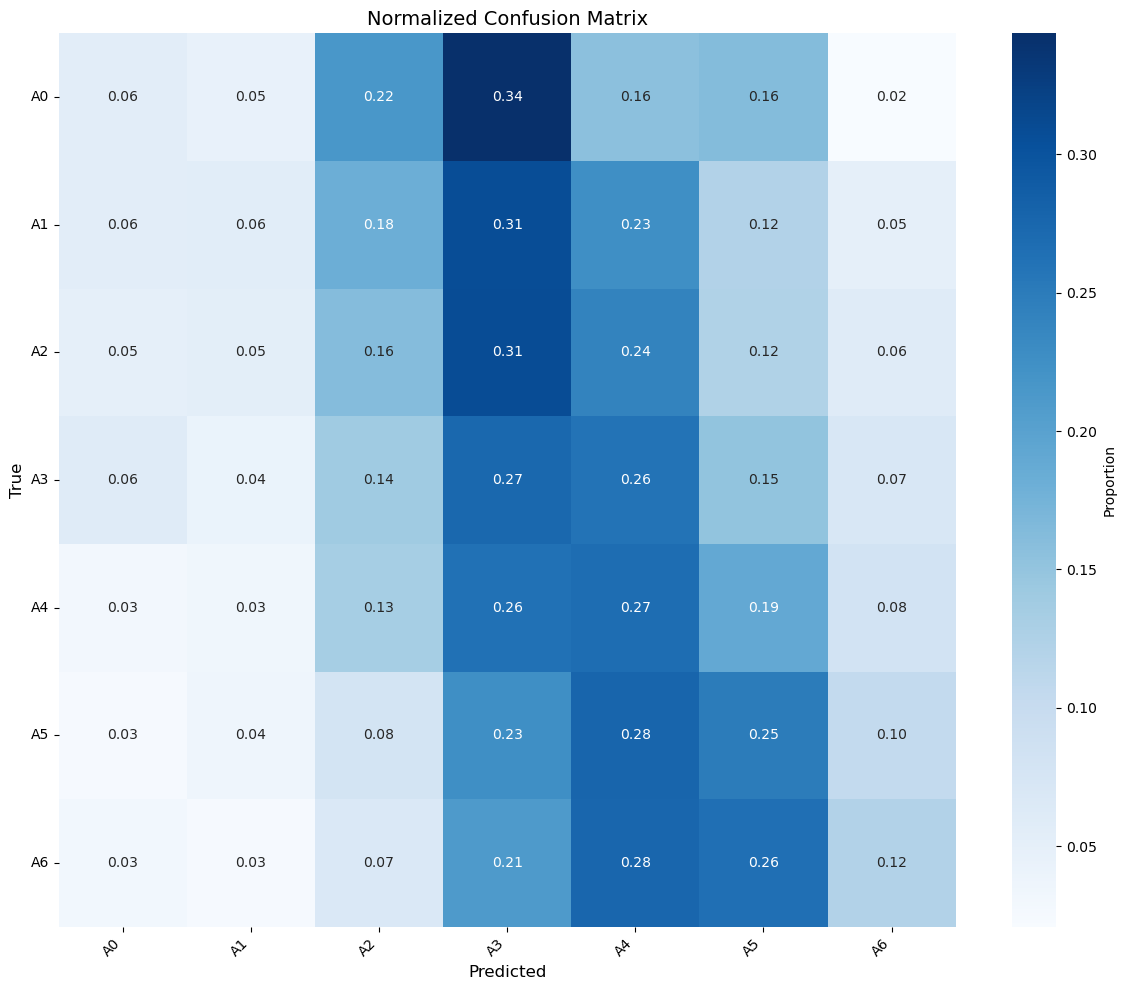


Epoch 16/20


Train Loss: 0.0578, Train Adjacent Accuracy: 0.7261, Train MAE: 0.9733, Train MSE: 2.1053

Epoch 17/20


Train Loss: 0.0580, Train Adjacent Accuracy: 0.7278, Train MAE: 0.9717, Train MSE: 2.1169

Epoch 18/20


KeyboardInterrupt: 

In [267]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Calculate weights
train_labels = [df.loc[train_indices[i], 'arousal_bin'] for i in range(len(train_indices))]
class_counts = np.bincount(train_labels)
class_weights_np = (1.0 / (class_counts + 1e-9))**1.5
class_weights_np = class_weights_np / class_weights_np.sum()
class_weights = torch.tensor(class_weights_np, device=DEVICE)

face_aro_train_dataset = FaceAroDataset(train_indices)
face_aro_test_dataset = FaceAroDataset(test_indices)

# Oversampling
sample_weights = [class_weights_np[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

face_aro_train_loader = DataLoader(
    face_aro_train_dataset, 
    batch_size=batch_size, 
    sampler=sampler
)

face_aro_test_loader = DataLoader(face_aro_test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
        face_aro_model, 
        face_aro_train_loader, 
        optimizer, 
        NUM_CLASSES=len(AROUSAL_BINS),
        class_weights=class_weights
    )
    print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_aro_model, 
            face_aro_test_loader, 
            arousal_bin_labels, 
            NUM_CLASSES=len(AROUSAL_BINS)
            )
        print_detailed_metrics(results, arousal_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

torch.save(face_aro_model.state_dict(), os.path.join(model_dir, "face_aro_model.pth"))

In [136]:
class SceneValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
        scene_feature = torch.load(feature_path)
        scene_feature = scene_feature.squeeze()

        return scene_feature.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)

In [137]:
scene_val_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS) - 1,       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)


Epoch 1/20


Train Loss: 0.5034, Train Adjacent Accuracy: 0.4847, Train MAE: 1.6374, Train MSE: 3.9238

Epoch 2/20


Train Loss: 0.4822, Train Adjacent Accuracy: 0.5488, Train MAE: 1.4995, Train MSE: 3.4632

Epoch 3/20


Train Loss: 0.4764, Train Adjacent Accuracy: 0.5608, Train MAE: 1.4835, Train MSE: 3.4429

Epoch 4/20


Train Loss: 0.4732, Train Adjacent Accuracy: 0.5731, Train MAE: 1.4588, Train MSE: 3.3620

Epoch 5/20


Train Loss: 0.4701, Train Adjacent Accuracy: 0.5779, Train MAE: 1.4521, Train MSE: 3.3708



Overall Metrics:
Loss:                0.4340
Accuracy (±1 bin):   0.5995

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2131       0.0343       0.0591       379       
V1              0.2145       0.2333       0.2235       583       
V2              0.1726       0.2937       0.2174       698       
V3              0.1644       0.3413       0.2219       668       
V4              0.2795       0.2989       0.2889       1228      
V5              0.2872       0.1650       0.2096       1018      
V6              0.6667       0.0067       0.0132       600       
----------------------------------------------------------------------
Macro Avg       0.2854       0.1962       0.1762       5174      
Weighted Avg    0.2844       0.2167       0.1988       5174      
MAE             1.3879      
MSE             3.1115      


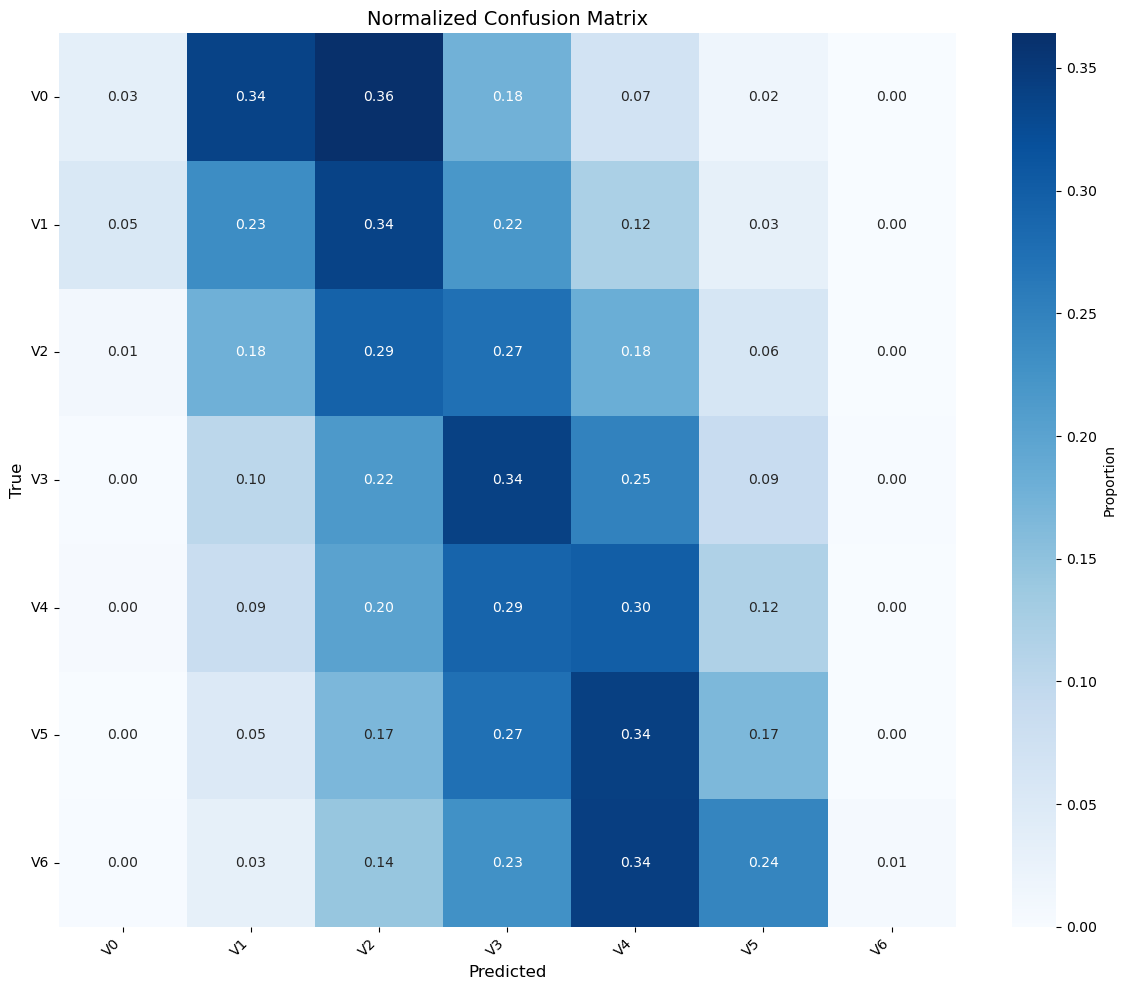


Epoch 6/20


Train Loss: 0.4702, Train Adjacent Accuracy: 0.5806, Train MAE: 1.4449, Train MSE: 3.3528

Epoch 7/20


Train Loss: 0.4672, Train Adjacent Accuracy: 0.5879, Train MAE: 1.4250, Train MSE: 3.2632

Epoch 8/20


KeyboardInterrupt: 

In [138]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    scene_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

# Calculate weights
train_labels = [df.loc[train_indices[i], 'valence_bin'] for i in range(len(train_indices))]
class_counts = np.bincount(train_labels)
class_weights_np = 1.0 / class_counts
class_weights_np = class_weights_np / class_weights_np.sum() * len(class_weights_np)
class_weights = torch.FloatTensor(class_weights_np).to(DEVICE)

scene_val_train_dataset = SceneValDataset(train_indices)
scene_val_test_dataset = SceneValDataset(test_indices)

# Oversampling
sample_weights = [class_weights_np[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

scene_val_train_loader = DataLoader(
    scene_val_train_dataset, 
    batch_size=batch_size, 
    sampler=sampler
)

scene_val_test_loader = DataLoader(scene_val_test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc_adj, train_mae, train_mse = train_epoch(
        scene_val_model, 
        scene_val_train_loader, 
        optimizer, 
        NUM_CLASSES=len(VALENCE_BINS),
        class_weights=class_weights
    )
    print(f"Train Loss: {train_loss:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            scene_val_model, 
            scene_val_test_loader, 
            valence_bin_labels, 
            NUM_CLASSES=len(VALENCE_BINS)
            )
        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

torch.save(scene_val_model.state_dict(), os.path.join(model_dir, "scene_val_model.pth"))

In [ ]:
scene_val_network = Network(scene_val_model, "scene_val_model", batching=True)

optimizer = torch.optim.AdamW(
    scene_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scene_val_network.optimizer = optimizer

In [ ]:
# scene_aro_model_raw = MLP(
#     512,        # input size
#     256, 64,   # hidden layers
#     len(AROUSAL_BINS),       # output size (arousal bins)   
#     activation=nn.ReLU,
#     softmax=False,   
#     batch=True
# )
# scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

In [ ]:
# class SceneAroDataset(TorchDataset):
#     def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "scenes")):
#         self.indices = indices
#         self.feature_dir = feature_dir

#     def __getitem__(self, idx):
#         if isinstance(idx, (tuple, list)):
#             idx = idx[0]
#         if isinstance(idx, Constant):
#             idx = int(idx.value)

#         idx = self.indices[idx]    
#         arousal_bin = df.loc[idx]['arousal_bin']
#         feature_path = os.path.join(self.feature_dir, f"scene_{idx}.pt")
#         scene_feature = torch.load(feature_path)
#         scene_feature = scene_feature.squeeze()

#         return scene_feature.to(DEVICE), arousal_bin
    
#     def __len__(self):
#         return len(self.indices)

In [ ]:
# scene_aro_train_dataset = SceneAroDataset(train_indices)
# scene_aro_test_dataset = SceneAroDataset(test_indices)

# scene_aro_train_loader = DataLoader(scene_aro_train_dataset, batch_size=batch_size, shuffle=True)
# scene_aro_test_loader = DataLoader(scene_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# class_counts = np.bincount(df['arousal_bin'].values)
# class_weights = 1.0 / (class_counts + 1e-6)
# class_weights /= class_weights.sum()

In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
#     # Train
#     train_loss, train_acc, train_acc_adj = train_epoch(
#         scene_aro_model, 
#         scene_aro_train_loader, 
#         optimizer, 
#         class_weights=class_weights, 
#         ce_weight=0.3, 
#         reg_weight=0.5,
#         adjacent_weight=0.2
#     )
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
#     if (epoch + 1) % 5 == 0:
#         # Evaluate
#         results = evaluate_with_metrics(
#             scene_aro_model, 
#             scene_aro_test_loader, 
#             arousal_bin_labels, 
#             class_weights=class_weights, 
#             ce_weight=0.3, 
#             reg_weight=0.5,
#             adjacent_weight=0.2
#         )
#         print_detailed_metrics(results, arousal_bin_labels)
#         # Plot confusion matrix
#         plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

# torch.save(scene_aro_model.state_dict(), os.path.join(model_dir, "scene_aro_model.pth"))
# Load the trained baseline model weights

scene_aro_model_raw = MLP(
    512,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)
scene_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "scene_aro_model.pth")))

<All keys matched successfully>

In [ ]:
scene_aro_network = Network(scene_aro_model, "scene_aro_model", batching=True)

optimizer = torch.optim.AdamW(
    scene_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scene_aro_network.optimizer = optimizer

In [ ]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face backbone features (768 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(768, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (768,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))        

In [ ]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (512,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_backbone"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_backbone"))

In [ ]:
emotion_centroids = {}
# For every emotion, count +3 for the valence value
for emo, (valence, arousal) in emotion_va.items():
    valence_centered = valence + 3
    emotion_centroids[emo] = (valence_centered, arousal)

In [ ]:
emotion_centroids

{'anger': (1.4243542435424354, 3.5912259122591226),
 'anticipation': (3.562447042874089, 2.463650228774784),
 'disgust': (2.124, 2.441),
 'fear': (1.6609745939192004, 3.239067055393586),
 'joy': (4.902050113895216, 2.9552961275626424),
 'sadness': (1.4292682926829268, 3.4221388367729833),
 'surprise': (3.4763513513513513, 2.5664414414414414),
 'trust': (4.414201183431953, 2.5694561848408)}

In [ ]:
class VA2Emotion(nn.Module):
    def __init__(self, centroids):
        super().__init__()
        self.centroids = nn.Parameter(torch.tensor(centroids, dtype=torch.float32), requires_grad=False)
        self.log_alpha = nn.Parameter(torch.tensor(0.0))  # learnable temperature

    def forward(self, valence, arousal):
        # Convert inputs to tensors if they're lists/scalars
        if not isinstance(valence, torch.Tensor):
            valence = torch.tensor(valence, dtype=torch.float32)
        if not isinstance(arousal, torch.Tensor):
            arousal = torch.tensor(arousal, dtype=torch.float32)
        
        # Move to correct device
        device = self.centroids.device
        valence = valence.to(device)
        arousal = arousal.to(device)
        
        # Ensure they are at least 1D
        if valence.dim() == 0:
            valence = valence.unsqueeze(0)
        if arousal.dim() == 0:
            arousal = arousal.unsqueeze(0)
            
        # Ensure they are 2D for broadcasting
        if valence.dim() == 1:
            valence = valence.unsqueeze(1)  # (batch, 1)
        if arousal.dim() == 1:
            arousal = arousal.unsqueeze(1)  # (batch, 1)
        
        V = valence  # (batch, 1)
        A = arousal  # (batch, 1)

        C = self.centroids  # shape (8, 2)
        # compute squared distances -> shape (batch, 8)
        d2 = (V - C[:, 0])**2 + (A - C[:, 1])**2
        
        # softmax over negative distances
        alpha = torch.exp(self.log_alpha)
        probs = F.softmax(-alpha * d2, dim=1)
        return probs

# Recreate the model with the fixed class
va2emotion_model_raw = VA2Emotion([list(emotion_centroids.values())])
va2emotion_model = DeviceAwareModule(va2emotion_model_raw).to(DEVICE)

va2emotion_network = Network(va2emotion_model, "va2emotion_model", batching=True)
va2emotion_network.optimizer = torch.optim.AdamW(
    va2emotion_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [ ]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_6.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network, va2emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

# model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

In [ ]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [ ]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),joy), {})

In [ ]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [ ]:
test_input = torch.load(os.path.join(data_dir, "pretrained_backbone", "faces", "face_0_0.pt")).to(DEVICE)
test_output = face_val_model(test_input.unsqueeze(0))
print(test_output)
test_output.shape

tensor([[5.3549e-04, 1.3191e-03, 2.4600e-03, 9.7618e-03, 9.2532e-02, 3.3119e-01,
         5.6220e-01]], device='cuda:0', grad_fn=<SqueezeBackward1>)


torch.Size([1, 7])

'trust'

In [ ]:
test_idx = np.random.choice(test_indices)

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("Emotion"))

print("Debugging queries done.")


Testing: test_face_val_bin
  test_face_val_bin(tensor(face_features_test(16865)),0): 0.3916
  test_face_val_bin(tensor(face_features_test(16865)),1): 0.2479
  test_face_val_bin(tensor(face_features_test(16865)),2): 0.1276
  test_face_val_bin(tensor(face_features_test(16865)),3): 0.1217
  test_face_val_bin(tensor(face_features_test(16865)),4): 0.0669
  test_face_val_bin(tensor(face_features_test(16865)),5): 0.0324
  test_face_val_bin(tensor(face_features_test(16865)),6): 0.0120

Testing: test_face_aro_bin
  test_face_aro_bin(tensor(face_features_test(16865)),3): 0.1622
  test_face_aro_bin(tensor(face_features_test(16865)),0): 0.1553
  test_face_aro_bin(tensor(face_features_test(16865)),1): 0.1543
  test_face_aro_bin(tensor(face_features_test(16865)),2): 0.1436
  test_face_aro_bin(tensor(face_features_test(16865)),4): 0.1348
  test_face_aro_bin(tensor(face_features_test(16865)),6): 0.1259
  test_face_aro_bin(tensor(face_features_test(16865)),5): 0.1239

Testing: test_scene_val_bin
  tes

In [ ]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:12.9760 	Average Loss:  1.9086233973503113
Iteration:  4 	s:26.2368 	Average Loss:  3.9864546060562134
Iteration:  6 	s:24.7883 	Average Loss:  3.528475135564804
Iteration:  8 	s:26.5274 	Average Loss:  3.418980821967125
Iteration:  10 	s:24.2322 	Average Loss:  3.172773204743862
Iteration:  12 	s:25.8730 	Average Loss:  3.1551909148693085
Iteration:  14 	s:24.9267 	Average Loss:  3.007840506732464
Iteration:  16 	s:25.3294 	Average Loss:  2.5445772036910057
Iteration:  18 	s:24.9283 	Average Loss:  2.4298143088817596
Iteration:  20 	s:27.1610 	Average Loss:  2.7054994106292725
Iteration:  22 	s:26.8331 	Average Loss:  2.2227362357079983
Iteration:  24 	s:23.5747 	Average Loss:  2.097135655581951
Iteration:  26 	s:25.1679 	Average Loss:  2.158589370548725
Iteration:  28 	s:26.3303 	Average Loss:  1.7333231717348099
Iteration:  30 	s:25.3958 	Average Loss:  2.040354438126087
Iteration:  32 	s:24.6838 	Average Loss:  1.7163233943283558
It

Exception ignored on calling ctypes callback function: <function _foreignWrapper.<locals>.wrapper at 0x00000223D74EF9A0>
Traceback (most recent call last):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\pyswip\easy.py", line 528, in wrapper
    r = fun(*args)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\engines\approximate_engine.py", line 154, in func
    probabilities = net([term2list(inputs, False)])
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 126, in __call__
    for inputs in zip(*inputs):
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 124, in <genexpr>
    inputs = (self.function(*e) for e in to_evaluate)
  File "c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\deepproblog\network.py", line 11, in tensor_function
    return tuple(network.model.get_tensor(arg) for arg in args)
  File "c:\Users\jarne\miniconda3\envs\dpl_ba

PrologError: Caused by: 'prove(final_emotion(tensor(face_features_train(15850)),tensor(scene_features_train(15850)),joy),10,Proofs,geometric_mean,false)'. Returned: 'error(domain_error(foreign_return_value, 12), context(/(face_val_model_extern, 2), _938))'.

In [ ]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.2284499420177812

Overall Metrics:
Accuracy: 0.2284

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.0714       0.0020       0.0038       511       
anticipation    0.2289       0.9983       0.3724       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.0000       0.0000       0.0000       1416      
sadness         0.0000       0.0000       0.0000       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.0375       0.1250       0.0470       5174      
Weighted Avg    0.0594       0.2284       0.0855       5174      


In [ ]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

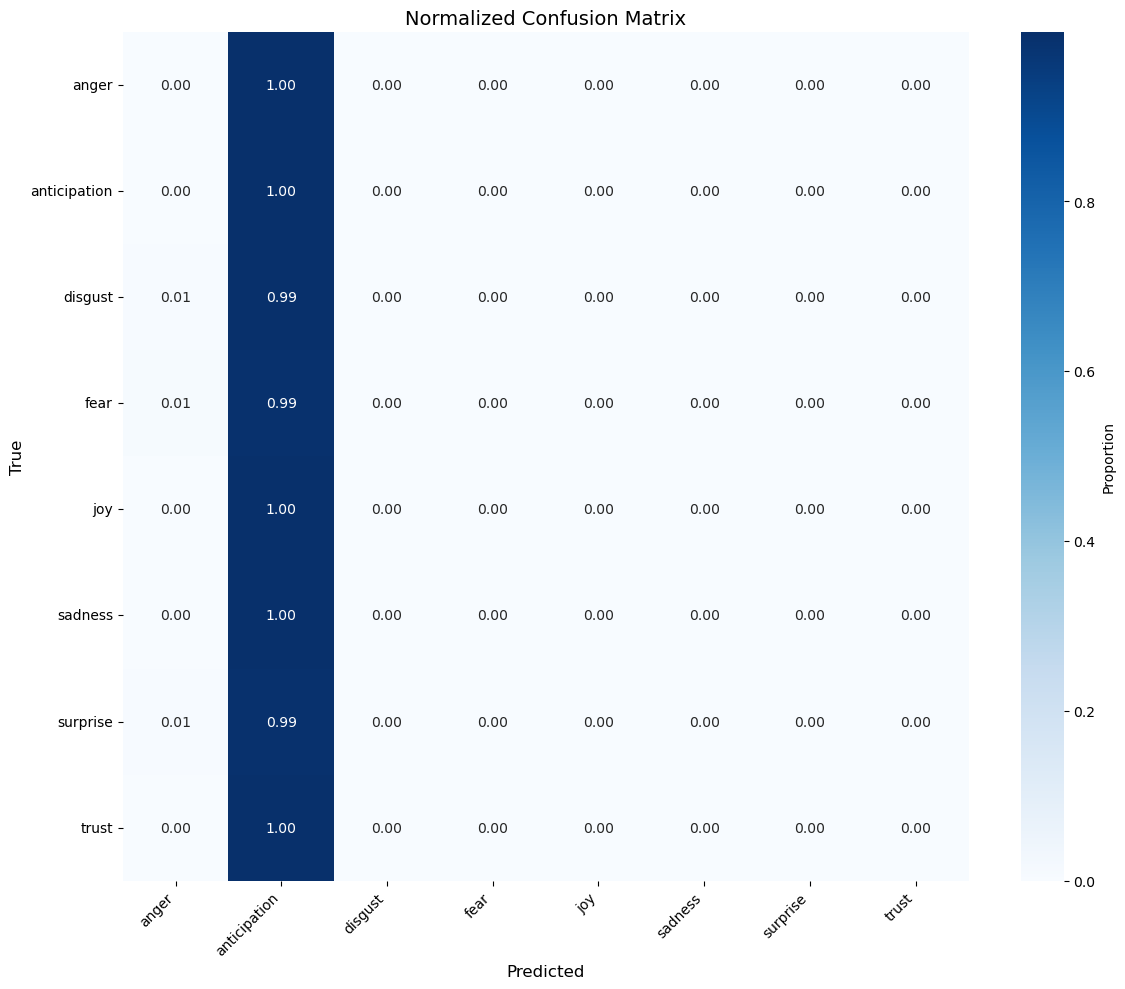

In [ ]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)